# 手写数字识别卷积神经网络

本文件是为了配合“迁移学习”内容而编写的文件，它的作用是将训练手写识别卷积神经网络，并将其保存在硬盘上以便迁移学习的时候能够读取该文件
本文件是集智AI学园http://campus.swarma.org 出品的“火炬上的深度学习”第IV课的配套源代码

In [1]:
# 导入所需要的包，请保证torchvision已经在你的环境中安装好
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.optim as optim
import torch.nn.functional as F

import torchvision.datasets as dsets
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

In [12]:
import os
os.chdir('D:/JupyterNotebook/深度学习原理与PyTorch实战-源代码/05_Convolution/')

In [13]:

# Hyper Parameters 
image_size = 28  #图像的总尺寸28*28
num_classes = 10  #标签的种类数
num_epochs = 20  #训练的总循环周期
batch_size = 64
learning_rate = 0.001

# 加载MINIST数据，如果没有下载过，就会在当前路径下新建/data子目录，并把文件存放其中

train_dataset = dsets.MNIST(root='./data',  #文件存放路径
                            train=True,   #提取训练集
                            transform=transforms.ToTensor(),  #将图像转化为Tensor
                            download=True)

test_dataset = dsets.MNIST(root='./data', 
                           train=False, 
                           transform=transforms.ToTensor())

# 训练数据集的加载器，自动将数据分割成batch，顺序随机打乱
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=batch_size, 
                                           shuffle=True)
# 测试数据集的加载器，自动将数据分割成batch
permutes = np.random.permutation(range(len(test_dataset)))
indices_val = permutes[:5000]
indices_test = permutes[5000:]
sampler_val = torch.utils.data.sampler.SubsetRandomSampler(indices_val)
sampler_test = torch.utils.data.sampler.SubsetRandomSampler(indices_test)
validation_loader = torch.utils.data.DataLoader(dataset =train_dataset,
                                                batch_size = batch_size,
                                                shuffle = False,
                                                sampler = sampler_val
                                               )
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                          batch_size=batch_size, 
                                          shuffle=False,
                                          sampler = sampler_test
                                         )

In [14]:
#定义卷积神经网络：4和8为人为指定的两个卷积层的厚度
depth = [4, 8]
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 4, 5, padding = 2) #输入通道为1，输出通道为4，窗口大小为5，padding为2
        self.pool = nn.MaxPool2d(2, 2) #一个窗口为2*2的pooling运算
        self.conv2 = nn.Conv2d(depth[0], depth[1], 5, padding = 2) #第二层卷积，输入通道为depth[0], 输出通道为depth[1]，窗口wei15，padding为2
        self.fc1 = nn.Linear(image_size // 4 * image_size // 4 * depth[1] , 512) #一个线性连接层，输入尺寸为最后一层立方体的平铺，输出层512个节点
        self.fc2 = nn.Linear(512, num_classes) #最后一层线性分类单元，输入为

    def forward(self, x):
        #神经网络完成一步前馈运算的过程，从输入到输出
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        # 将立体的Tensor全部转换成一维的Tensor。两次pooling操作，所以图像维度减少了1/4
        x = x.view(-1, image_size // 4 * image_size // 4 * depth[1])
        x = F.relu(self.fc1(x)) #全链接，激活函数
        x = F.dropout(x, training=self.training) #以默认为0.5的概率对这一层进行dropout操作
        x = self.fc2(x) #全链接，激活函数
        x = F.log_softmax(x, dim = 1) #log_softmax可以理解为概率对数值
        return x
    
    def retrieve_features(self, x):
        #提取卷积神经网络的特征图的函数，返回feature_map1, feature_map2为前两层卷积层的特征图
        feature_map1 = F.relu(self.conv1(x))
        x = self.pool(feature_map1)
        feature_map2 = F.relu(self.conv2(x))
        return (feature_map1, feature_map2)
    

In [15]:
def rightness(predictions, labels):
    """计算预测错误率的函数，其中predictions是模型给出的一组预测结果，batch_size行10列的矩阵，labels是数据之中的正确答案"""
    pred = torch.max(predictions.data, 1)[1] # 对于任意一行（一个样本）的输出值的第1个维度，求最大，得到每一行的最大元素的下标
    rights = pred.eq(labels.data.view_as(pred)).sum() #将下标与labels中包含的类别进行比较，并累计得到比较正确的数量
    return rights, len(labels) #返回正确的数量和这一次一共比较了多少元素
net = ConvNet() #新建一个卷积神经网络的实例

criterion = nn.CrossEntropyLoss() #Loss函数的定义
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9) #定义优化器

record = [] #记录准确率等数值的容器
weights = [] #每若干步就记录一次卷积核

#开始训练循环
for epoch in range(num_epochs):
    
    train_rights = [] #记录训练数据集准确率的容器
    for batch_idx, (data, target) in enumerate(train_loader):  #针对容器中的每一个批进行循环
        data, target = data.clone().detach().requires_grad_(True), target.clone().detach() #将Tensor转化为Variable，data为图像，target为标签
        net.train() # 给网络模型做标记，标志说模型在训练集上训练
        output = net(data) #完成一次预测
        loss = criterion(output, target) #计算误差
        optimizer.zero_grad() #清空梯度
        loss.backward() #反向传播
        optimizer.step() #一步随机梯度下降
        right = rightness(output, target) #计算准确率所需数值，返回正确的数值为（正确样例数，总样本数）
        train_rights.append(right) #将计算结果装到列表容器中

    
        if batch_idx % 100 == 0: #每间隔100个batch执行一次
            
            #train_r为一个二元组，分别记录训练集中分类正确的数量和该集合中总的样本数
            train_r = (sum([tup[0] for tup in train_rights]), sum([tup[1] for tup in train_rights]))
            
            net.eval() # 给网络模型做标记，标志说模型在训练集上训练
            val_rights = [] #记录校验数据集准确率的容器
            for (data, target) in validation_loader:
                data, target = data.clone().detach().requires_grad_(True), target.clone().detach() 
                output = net(data) #完成一次预测
                right = rightness(output, target) #计算准确率所需数值，返回正确的数值为（正确样例数，总样本数）
                val_rights.append(right)
            
            #val_r为一个二元组，分别记录校验集中分类正确的数量和该集合中总的样本数
            val_r = (sum([tup[0] for tup in val_rights]), sum([tup[1] for tup in val_rights]))
            
            #打印准确率等数值，其中正确率为本训练周期Epoch开始后到目前撮的正确率的平均值
            print('训练周期: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}\t训练正确率: {:.2f}%\t校验正确率: {:.2f}%'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader),
                loss.data, 
                100. * train_r[0].numpy() / train_r[1], 
                100. * val_r[0].numpy() / val_r[1]))
            
            #将准确率和权重等数值加载到容器中，以方便后续处理
            record.append((100 - 100. * train_r[0].numpy() / train_r[1], 100 - 100. * val_r[0].numpy() / val_r[1]))
            weights.append([net.conv1.weight.data.clone(), net.conv1.bias.data.clone(), 
                            net.conv2.weight.data.clone(), net.conv2.bias.data.clone()])
            

训练周期: 0 [0/60000 (0%)]	Loss: 2.308936	训练正确率: 3.12%	校验正确率: 9.70%
训练周期: 0 [800/60000 (11%)]	Loss: 2.303631	训练正确率: 9.78%	校验正确率: 9.96%
训练周期: 0 [1600/60000 (21%)]	Loss: 2.282449	训练正确率: 10.91%	校验正确率: 12.48%
训练周期: 0 [2400/60000 (32%)]	Loss: 2.265794	训练正确率: 12.62%	校验正确率: 15.76%
训练周期: 0 [3200/60000 (43%)]	Loss: 2.204023	训练正确率: 15.15%	校验正确率: 43.00%
训练周期: 0 [4000/60000 (53%)]	Loss: 1.745055	训练正确率: 20.23%	校验正确率: 71.42%
训练周期: 0 [4800/60000 (64%)]	Loss: 0.970608	训练正确率: 27.36%	校验正确率: 77.92%
训练周期: 0 [5600/60000 (75%)]	Loss: 0.732174	训练正确率: 34.27%	校验正确率: 82.94%
训练周期: 0 [6400/60000 (85%)]	Loss: 0.534779	训练正确率: 40.11%	校验正确率: 86.46%
训练周期: 0 [7200/60000 (96%)]	Loss: 0.382045	训练正确率: 44.96%	校验正确率: 88.18%
训练周期: 1 [0/60000 (0%)]	Loss: 0.537758	训练正确率: 82.81%	校验正确率: 88.98%
训练周期: 1 [800/60000 (11%)]	Loss: 0.443771	训练正确率: 86.70%	校验正确率: 89.28%
训练周期: 1 [1600/60000 (21%)]	Loss: 0.438019	训练正确率: 86.97%	校验正确率: 90.32%
训练周期: 1 [2400/60000 (32%)]	Loss: 0.534258	训练正确率: 87.20%	校验正确率: 90.98%
训练周期: 1 [3200/60000 (43%)]	Loss: 0

训练周期: 11 [5600/60000 (75%)]	Loss: 0.053505	训练正确率: 97.38%	校验正确率: 98.22%
训练周期: 11 [6400/60000 (85%)]	Loss: 0.109054	训练正确率: 97.41%	校验正确率: 98.34%
训练周期: 11 [7200/60000 (96%)]	Loss: 0.169888	训练正确率: 97.40%	校验正确率: 98.32%
训练周期: 12 [0/60000 (0%)]	Loss: 0.038727	训练正确率: 98.44%	校验正确率: 98.18%
训练周期: 12 [800/60000 (11%)]	Loss: 0.077708	训练正确率: 97.90%	校验正确率: 98.26%
训练周期: 12 [1600/60000 (21%)]	Loss: 0.095359	训练正确率: 97.82%	校验正确率: 98.38%
训练周期: 12 [2400/60000 (32%)]	Loss: 0.040391	训练正确率: 97.57%	校验正确率: 98.30%
训练周期: 12 [3200/60000 (43%)]	Loss: 0.124837	训练正确率: 97.54%	校验正确率: 98.24%
训练周期: 12 [4000/60000 (53%)]	Loss: 0.099167	训练正确率: 97.58%	校验正确率: 98.38%
训练周期: 12 [4800/60000 (64%)]	Loss: 0.018569	训练正确率: 97.61%	校验正确率: 98.42%
训练周期: 12 [5600/60000 (75%)]	Loss: 0.041253	训练正确率: 97.57%	校验正确率: 98.28%
训练周期: 12 [6400/60000 (85%)]	Loss: 0.038803	训练正确率: 97.54%	校验正确率: 98.42%
训练周期: 12 [7200/60000 (96%)]	Loss: 0.132479	训练正确率: 97.54%	校验正确率: 98.44%
训练周期: 13 [0/60000 (0%)]	Loss: 0.034241	训练正确率: 98.44%	校验正确率: 98.44%
训练周期: 13 [800/6

## 保存模型

In [16]:
os.chdir(r'D:\JupyterNotebook\深度学习原理与PyTorch实战-源代码\06_Transfer Learning')
# 在这里保存已经训练好的神经网络
torch.save(net, 'minst_conv_checkpoint') #后面的字符串为保存文件的路径

D:\Anacoda3\lib\site-packages\torch\serialization.py:256: UserWarning: Couldn't retrieve source code for container of type ConvNet. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


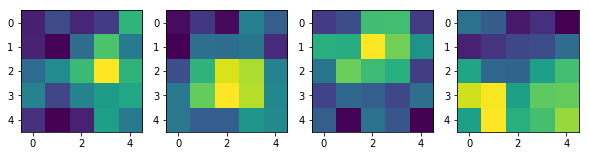

In [17]:
#提取第一层卷积层的卷积核
plt.figure(figsize = (10, 7))
for i in range(4):
    plt.subplot(1,4,i + 1)
    plt.imshow(net.conv1.weight.data.numpy()[i,0,...])


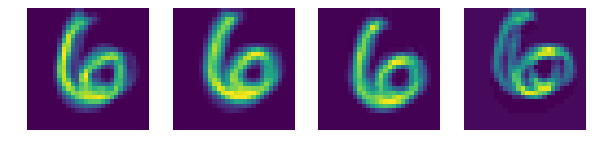

In [19]:
#调用net的retrieve_features方法可以抽取出喂入当前数据后吐出来的所有特征图（第一个卷积和第二个卷积层）

#首先定义读入的图片
idx =100
#它是从test_dataset中提取第idx个批次的第0个图，其次unsqueeze的作用是在最前面添加一维，
#目的是为了让这个input_x的tensor是四维的，这样才能输入给net。补充的那一维表示batch。
input_x = test_dataset[idx][0].unsqueeze(0) 
feature_maps = net.retrieve_features(input_x) #feature_maps是有两个元素的列表，分别表示第一层和第二层卷积的所有特征图

plt.figure(figsize = (10, 7))

#有四个特征图，循环把它们打印出来
for i in range(4):
    plt.subplot(1,4,i + 1)
    plt.axis('off')
    plt.imshow(feature_maps[0][0, i,...].data.numpy())

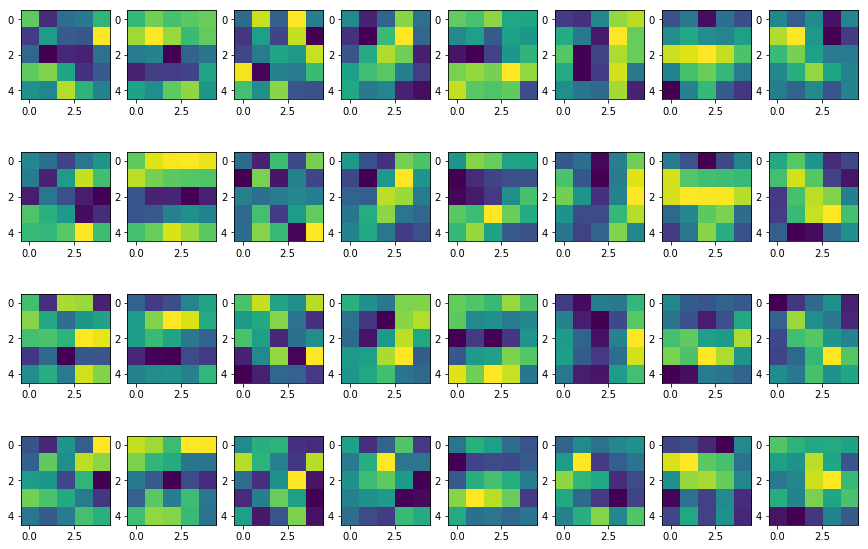

In [20]:
# 绘制第二层的卷积核
plt.figure(figsize = (15, 10))
for i in range(4):
    for j in range(8):
        plt.subplot(4, 8, i * 8 + j + 1)
        plt.imshow(net.conv2.weight.data.numpy()[j, i,...])

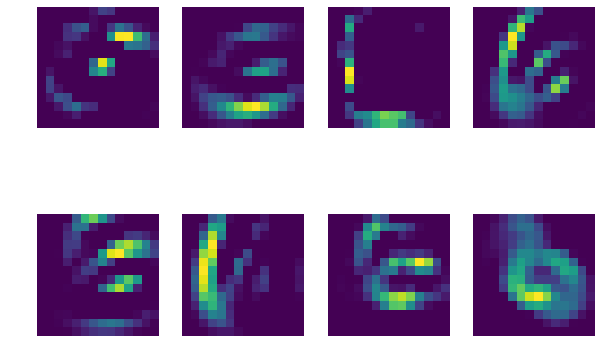

In [21]:
plt.figure(figsize = (10, 7))
for i in range(8):
    plt.subplot(2,4,i + 1)
    plt.axis('off')
    plt.imshow(feature_maps[1][0, i,...].data.numpy())
    

In [22]:
#在测试集上分批运行，并计算总的正确率
net.eval() #标志模型当前为运行阶段
vals = [] #记录准确率所用列表

#对测试数据集进行循环
for data, target in test_loader:
    data, target = data.clone().detach().requires_grad_(True), target.clone().detach()
    output = net(data) #将特征数据喂入网络，得到分类的输出
    val = rightness(output, target) #获得正确样本数以及总样本数
    vals.append(val) #记录结果

#计算准确率
rights = (sum([tup[0] for tup in vals]), sum([tup[1] for tup in vals]))
right_rate = 100. * rights[0].numpy() / rights[1]
print(right_rate)

98.92


标签是： 9


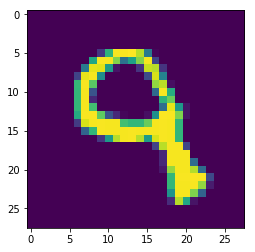

In [23]:
#随便从测试集中读入一张图片，并检验模型的分类结果，并绘制出来
idx = 4000
muteimg = test_dataset[idx][0].numpy()
plt.imshow(muteimg[0,...])
print('标签是：',test_dataset[idx][1])